# Fink REST API - How-to

## HBase in Fink

- Used as the backend for our web services (incl. REST API)
- Updated once a night, at the end of the observing night
- Support concurrency & can deal simultaneously with hundreds of requests without problems

![](images/rest_api.png)

## Retrieve object data

The list of arguments for retrieving object data can be found at https://fink-portal.org/api/v1/objects.

In a unix shell, you would simply use

```bash
# Get data for ZTF21aaxtctv and save it in a CSV file
curl -H "Content-Type: application/json" -X POST -d '{"objectId":"ZTF21aaxtctv", "output-format":"csv"}' https://fink-portal.org/api/v1/objects -o ZTF21aaxtctv.csv

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/objects?objectId=ZTF21aaxtctv&output-format=json" -O ZTF21aaxtctv.json
```

In python, you would use

In [1]:
import requests
import pandas as pd

# get data for ZTF21aaxtctv
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF21aaxtctv',
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

In [2]:
pdf.head(2)

,b:cutoutDifference_stampData,b:cutoutScience_stampData,b:cutoutTemplate_stampData,d:cdsxmatch,d:mulens,d:nalerthist,d:rf_kn_vs_nonkn,d:rf_snia_vs_nonia,d:roid,d:snn_sn_vs_all,...,d:tracklet,v:classification,v:g-r,v:rate(g-r),v:dg,v:rate(dg),v:dr,v:rate(dr),v:lastdate,v:constellation
0,binary:ZTF21aaxtctv_2459537.0520833:cutoutDiff...,binary:ZTF21aaxtctv_2459537.0520833:cutoutScie...,binary:ZTF21aaxtctv_2459537.0520833:cutoutTemp...,Unknown,0.0,5,0,0.0,0,0.0,...,,Unknown,NaN,NaN,0.0,0.0,0.023330,9.880839,2021-11-18 13:14:59.997,Virgo
1,binary:ZTF21aaxtctv_2459537.0497222:cutoutDiff...,binary:ZTF21aaxtctv_2459537.0497222:cutoutScie...,binary:ZTF21aaxtctv_2459537.0497222:cutoutTemp...,Unknown,0.0,4,0,0.0,0,0.0,...,,Unknown,NaN,NaN,0.0,0.0,-0.036741,-15.560908,2021-11-18 13:11:35.998,Virgo


You can also retrieve the data for several objects at once:

In [3]:
mylist = ['ZTF21aaxtctv', 'ZTF21abfmbix', 'ZTF21abfaohe']

# get data for many objects
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(mylist),
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Note that for `csv` output, you need to use

```python
# get data for ZTF21aaxtctv in CSV format...
r = ...

pd.read_csv(io.BytesIO(r.content))
```

You can also get a votable:

```python
import io
from astropy.io import votable

# get data for ZTF21aaxtctv in JSON format...
r = ...

vt = votable.parse(io.BytesIO(r.content))
```

By default, we transfer all available data fields (original ZTF fields and Fink science module outputs).
But you can also choose to transfer only a subset of the fields:

In [4]:
def load_all_fields():
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': 'ZTF21aaxtctv',
      }
    )
    return r
    
def load_some_fields():
    """ Select only jd, and magpsf
    
    Note that the fields should be comma-separated. 
    Unknown field names are ignored. 
    This will speed-up dramatically results in some cases:    
    """
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': 'ZTF21aaxtctv',
        'columns': 'i:jd,i:magpsf'
      }
    )
    return r

In [5]:
%timeit load_all_fields()

545 ms ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit load_some_fields()

83 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
pdf = pd.read_json(load_some_fields().content)
pdf.head(2)

,i:jd,i:magpsf
0,2.459537e+06,19.149723
1,2.459537e+06,19.170815


### Upper limits and bad quality data

You can also retrieve upper limits and bad quality data (as defined by Fink quality cuts)
alongside valid measurements. For this you would use `withupperlim` (see usage below).
Note that the returned data will contained a new column, `d:tag`, to easily check data type:
`valid` (valid alert measurements), `upperlim` (upper limits), `badquality` (alert measurements that did not pass quality cuts).
Here is an example that query the data, and plot it:

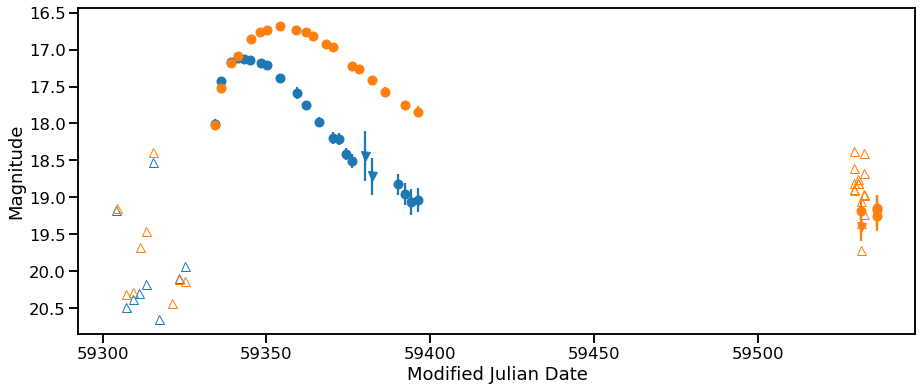

In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# get data for ZTF21aaxtctv
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF21aaxtctv',
    'withupperlim': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

def plot_photometry(pdf):
    fig = plt.figure(figsize=(15, 6))

    colordic = {1: 'C0', 2: 'C1'}

    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()
plot_photometry(pdf)

### Cutouts

Finally, you can also request data from cutouts stored in alerts (science, template and difference).
Simply set `withcutouts` in the json payload (string):

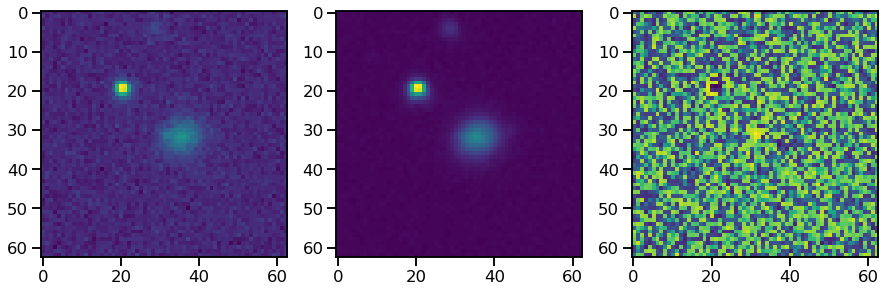

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

columns = [
    'b:cutoutScience_stampData',
    'b:cutoutTemplate_stampData',
    'b:cutoutDifference_stampData'
]

# transfer cutout data
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF21aaxtctv',
        'withcutouts': 'True',
        'cols': ','.join(columns)
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for col in columns:
    # 2D array
    data = pdf[col].values[0]

    axes[columns.index(col)].imshow(np.arcsinh(data))

plt.show()

## Retrieve cutout data from the Fink database

The list of arguments for retrieving cutout data can be found at https://fink-portal.org/api/v1/cutouts.

### PNG

In a unix shell, you can retrieve the last cutout of an object by simply using

```bash
curl -H "Content-Type: application/json" \\
    -X POST -d \\
    '{"objectId":"ZTF21aaxtctv", "kind":"Science"}' \\
    https://fink-portal.org/api/v1/cutouts -o cutoutScience.png

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/cutouts?objectId=ZTF21aaxtctv&kind=Science" -O ZTF21aaxtctv_Science.png
```

This will retrieve the `Science` image and save it on `cutoutScience.png`.
In Python, the equivalent script would be:

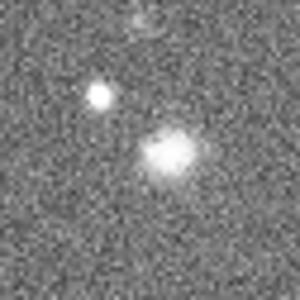

In [10]:
import io
import requests
from PIL import Image as im

# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/cutouts',
    json={
        'objectId': 'ZTF21aaxtctv',
        'kind': 'Science',
    }
)

image = im.open(io.BytesIO(r.content))
image.resize((300, 300))

Note you can choose between the `Science`, `Template`, or `Difference` images.
You can also customise the image treatment by

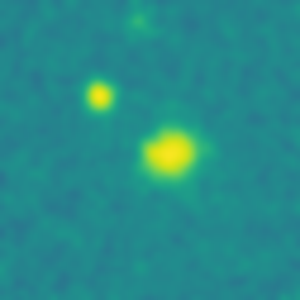

In [11]:
import io
import requests
from PIL import Image as im

# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/cutouts',
    json={
        'objectId': 'ZTF21aaxtctv',
        'kind': 'Science', # Science, Template, Difference
        'stretch': 'sigmoid', # sigmoid[default], linear, sqrt, power, log
        'colormap': 'viridis', # Valid matplotlib colormap name (see matplotlib.cm). Default is grayscale.
        'pmin': 0.5, # The percentile value used to determine the pixel value of minimum cut level. Default is 0.5. No effect for sigmoid.
        'pmax': 99.5, # The percentile value used to determine the pixel value of maximum cut level. Default is 99.5. No effect for sigmoid.
        'convolution_kernel': 'gauss' # Convolve the image with a kernel (gauss or box). Default is None (not specified).
    }
)

image = im.open(io.BytesIO(r.content))
# image.save('mysupercutout.png')
image.resize((300, 300))

By default, you will retrieve the cutout of the last alert emitted for the object `objectId`.
You can also access cutouts of other alerts from this object by specifying their candidate ID:

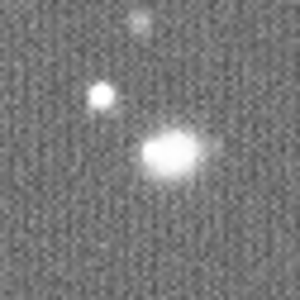

In [12]:
import io
import requests
import pandas as pd
from PIL import Image as im

# Get all candidate ID with JD for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF21aaxtctv',
        'columns': 'i:candid,i:jd'
    }
)

pdf_candid = pd.read_json(r.content)
# Get the first alert
first_alert = pdf_candid['i:candid'].values[-1]

# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/cutouts',
    json={
        'objectId': 'ZTF21aaxtctv',
        'kind': 'Science',
        'candid': str(first_alert)
    }
)

image = im.open(io.BytesIO(r.content))
# image.save('mysupercutout_firstalert.png')
image.resize((300, 300))

### FITS

You can also retrieve the original FITS file stored in the alert:

```bash
curl -H "Content-Type: application/json" \\
    -X POST -d \\
    '{"objectId":"ZTF21aaxtctv", "kind":"Science", "output-format": "FITS"}' \\
    https://fink-portal.org/api/v1/cutouts -o cutoutScience.fits
```

or equivalently in Python:

In [13]:
import io
from astropy.io import fits
import requests
import pandas as pd

# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/cutouts',
    json={
        'objectId': 'ZTF21aaxtctv',
        'kind': 'Science',
        'output-format': 'FITS'
    }
)

data = fits.open(io.BytesIO(r.content), ignore_missing_simple=True)
# data.writeto('cutoutScience.fits')
data

### Numpy array

You can also retrieve only the data block stored in the alert:

In [14]:
import requests
import pandas as pd

# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/cutouts',
    json={
        'objectId': 'ZTF21aaxtctv',
        'kind': 'Science',
        'output-format': 'array'
    }
)

pdf = pd.read_json(r.content)
array = pdf['b:cutoutScience_stampData'].values[0]
np.shape(array)

(63, 63)

## Conesearch

Perform a conesearch around a position on the sky given by (RA, Dec, radius).
The initializer for RA/Dec is very flexible and supports inputs provided in a number of convenient formats.
The following ways of initializing a conesearch are all equivalent (radius in arcsecond):

* 193.822, 2.89732, 5
* 193d49m18.267s, 2d53m50.35s, 5
* 12h55m17.218s, +02d53m50.35s, 5
* 12 55 17.218, +02 53 50.35, 5
* 12:55:17.218, 02:53:50.35, 5

In a unix shell, you would simply use

```bash
# Get all objects falling within (center, radius) = ((ra, dec), radius)
curl -H "Content-Type: application/json" -X POST -d '{"ra":"193.822", "dec":"2.89732", "radius":"5"}' https://fink-portal.org/api/v1/explorer -o conesearch.json

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/explorer?ra=193.822&dec=2.89732&radius=5&startdate_conesearch=2021-06-25 05:59:37.000&window_days_conesearch=7&output-format=json" -O conesearch.json
```

In python, you would use

In [15]:
import requests
import pandas as pd

# Get all objects falling within (center, radius) = ((ra, dec), radius)
r = requests.post(
  'https://fink-portal.org/api/v1/explorer',
  json={
    'ra': '193.822',
    'dec': '2.89732',
    'radius': '5'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Maximum radius length is 18,000 arcseconds (5 degrees). Note that in case of
several objects matching, the results will be sorted according to the column
`v:separation_degree`, which is the angular separation in degree between
the input (ra, dec) and the objects found. Also note this focuses on ALERTS, not OBJECTS, because the classification in Fink is done for alerts.

In addition, you can specify time boundaries:

In [16]:
import requests
import pandas as pd

# Get all objects falling within (center, radius) = ((ra, dec), radius)
# between 2021-06-25 05:59:37.000 (included) and 2021-07-01 05:59:37.000 (excluded)
r = requests.post(
  'https://fink-portal.org/api/v1/explorer',
  json={
    'ra': '193.822',
    'dec': '2.89732',
    'radius': '5',
    'startdate_conesearch': '2021-06-25 05:59:37.000',
    'window_days_conesearch': 7
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Here is the performance of the service for querying a
single object (database of 1.3TB, about 40 million alerts):

![conesearch](https://user-images.githubusercontent.com/20426972/123047697-e493a500-d3fd-11eb-9f30-216dce9cbf43.png)

_circle marks with dashed lines are results for a full scan search
(~2 years of data, 40 million alerts), while the upper triangles with
dotted lines are results when restraining to 7 days search.
The numbers close to markers show the number of objects returned by the conesearch._

## Search by Date

Choose a starting date and a time window to see all alerts in this period.
Dates are in UTC, and the time window in minutes.
Example of valid search:

* 2021-07-01 05:59:37.000

In a unix shell, you would simply use

```bash
# Get all objects between 2021-07-01 05:59:37.000 and 2021-07-01 06:09:37.000 UTC
curl -H "Content-Type: application/json" -X POST -d '{"startdate":"2021-07-01 05:59:37.000", "window":"10"}' https://fink-portal.org/api/v1/explorer -o datesearch.json

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/explorer?startdate=2021-07-01 05:59:37.000&window=10&output-format=json" -O datesearch.json
```

In python, you would use

In [17]:
import requests
import pandas as pd

# Get all objects between 2021-07-01 05:59:37.000 and 2021-07-01 06:09:37.000 UTC
r = requests.post(
  'https://fink-portal.org/api/v1/explorer',
  json={
    'startdate': '2021-07-01 05:59:37.000',
    'window': '10'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

You can see it takes some time to load the data, because we currently transfer all columns... Modifications will be done soon.

In [18]:
pdf.sort_values('d:rf_snia_vs_nonia', ascending=False)

,d:cdsxmatch,d:mulens,d:rf_kn_vs_nonkn,d:rf_snia_vs_nonia,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,d:tracklet,i:candid,i:chipsf,...,i:sigmapsf,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:lastdate,v:constellation
2464,Unknown,0.0,0,0.135,0,0.009939,0.868732,nan,1642249732315015013,53.030850,...,0.028584,-999,-999.0,null,0,855.9870,2451.6245,SN candidate,2021-07-01 05:59:37.000,Virgo
2023,Unknown,0.0,0,0.106,0,0.000000,0.000000,nan,1642250831115015010,1.783729,...,0.107317,-999,-999.0,null,0,1361.1305,1611.5293,Unknown,2021-07-01 06:01:11.997,Libra
2084,Unknown,0.0,0,0.087,0,0.000000,0.000000,nan,1642250830315015024,1.368616,...,0.132419,-999,-999.0,null,0,2018.6060,1784.6932,Unknown,2021-07-01 06:01:11.997,Scorpius
2074,Unknown,0.0,0,0.046,0,0.000000,0.000000,nan,1642250831715015009,15.777208,...,0.097214,-999,-999.0,null,0,1106.7772,1492.5022,Unknown,2021-07-01 06:01:11.997,Scorpius
141,Unknown,0.0,0,0.046,0,0.000000,0.000000,nan,1642251786315010005,10.625117,...,0.156160,-999,-999.0,null,0,259.8762,1471.4307,Unknown,2021-07-01 06:02:33.999,Ophiucus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,Unknown,0.0,0,0.000,3,0.000000,0.000000,nan,1642251300915015019,1.544776,...,0.208598,0,19.7,118311,0,299.8589,2342.6077,Solar System MPC,2021-07-01 06:01:53.003,Libra
838,Unknown,0.0,0,0.000,3,0.000000,0.000000,nan,1642251300915015018,0.986492,...,0.169158,0,19.4,141633,0,1017.9193,2897.4468,Solar System MPC,2021-07-01 06:01:53.003,Libra
839,Unknown,0.0,0,0.000,3,0.000000,0.000000,nan,1642251300915015013,1.365358,...,0.146369,0,19.5,35424,0,2461.6987,1223.7521,Solar System MPC,2021-07-01 06:01:53.003,Libra
840,V*,0.0,0,0.000,0,0.000000,0.000000,nan,1642251301615010001,9.958154,...,0.167798,-999,-999.0,null,0,625.7769,491.2318,V*,2021-07-01 06:01:53.003,Scorpius


Please, note this focuses on ALERTS, not OBJECTS, because the classification in Fink is done for alerts.

## Get latest alerts by class

The list of arguments for getting latest alerts by class can be found at https://fink-portal.org/api/v1/latests.

The list of Fink class can be found at https://fink-portal.org/api/v1/classes

```bash
# Get list of available class in Fink
curl -H "Content-Type: application/json" -X GET https://fink-portal.org/api/v1/classes -o finkclass.json
```

To get the last 5 candidates of the class `Early SN Ia candidate`, you would simply use in a unix shell:

```bash
# Get latests 5 Early SN Ia candidates
curl -H "Content-Type: application/json" -X POST -d '{"class":"Early SN Ia candidate", "n":"5"}' https://fink-portal.org/api/v1/latests -o latest_five_sn_candidates.json

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/latests?class=Early SN Ia candidate&n=5&output-format=json" -O latest_five_sn_candidates.json
```

In python, you would use

In [19]:
import requests
import pandas as pd

# Get latests 5 Early SN Ia candidates
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': 'Early SN Ia candidate',
    'n': '5'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Note that for `csv` output, you need to use

```python
# get latests in CSV format...
r = ...

pd.read_csv(io.BytesIO(r.content))
```

You can also specify `startdate` and `stopdate` for your search:

In [20]:
import requests
import pandas as pd

# Get all classified SN Ia from TNS between March 1st 2021 and March 5th 2021
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': '(TNS) SN Ia',
    'n': '100',
    'startdate': '2021-03-01',
    'stopdate': '2021-03-05'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Please, note this focuses on ALERTS, not OBJECTS, because the classification in Fink is done for alerts. If you then want to get the photometry for all objects, you need to query again the database using the `api/v1/objects` endpoint:

In [21]:
pdf = pdf.sort_values('i:ndethist', ascending=True)
my_alert = pdf['i:objectId'].values[0]
my_alert

'ZTF21aanyfqu'

In [22]:
# get data for ZTF21aaxtctv
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': my_alert,
        'withupperlim': 'True',
        'output-format': 'json'
    }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

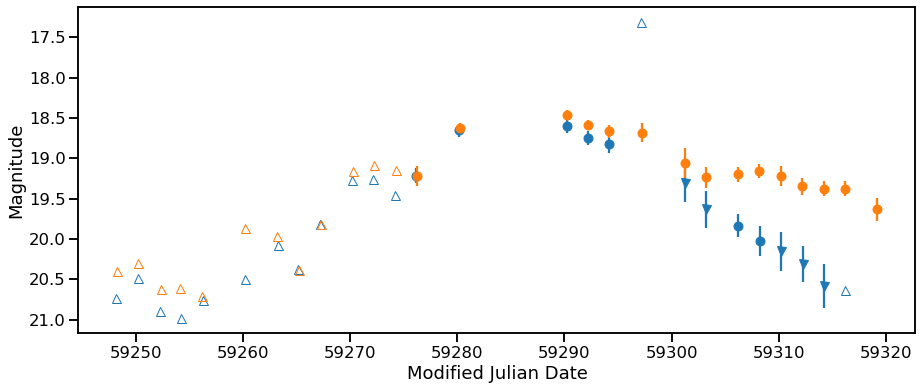

In [23]:
plot_photometry(pdf)

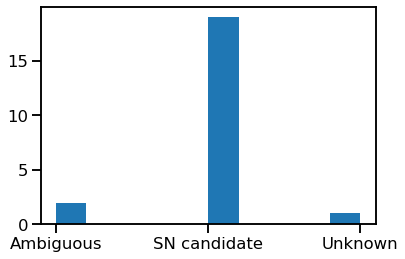

In [24]:
mask = pdf['d:tag'] == 'valid'
plt.hist(pdf['v:classification'][mask].values);

## Retrieve Solar System Object data

The list of arguments for retrieving SSO data can be found at https://fink-portal.org/api/v1/sso.
The numbers or designations are taken from the MPC archive.
When searching for a particular asteroid or comet, it is best to use the IAU number,
as in 8467 for asteroid "8467 Benoitcarry". You can also try for numbered comet (e.g. 10P),
or interstellar object (none so far...). If the number does not yet exist, you can search for designation.
Here are some examples of valid queries:

* Asteroids by number (default)
  * Asteroids (Main Belt): 8467, 1922
  * Asteroids (Hungarians): 18582, 77799
  * Asteroids (Jupiter Trojans): 4501, 1583
  * Asteroids (Mars Crossers): 302530
* Asteroids by designation (if number does not exist yet)
  * 2010JO69, 2017AD19, 2012XK111
* Comets by number (default)
  * 10P, 249P, 124P
* Comets by designation (if number does no exist yet)
  * C/2020V2, C/2020R2

Note for designation, you can also use space (2010 JO69 or C/2020 V2).

In a unix shell, you would simply use

```bash
# Get data for the asteroid 8467 and save it in a CSV file
curl -H "Content-Type: application/json" -X POST -d '{"n_or_d":"8467", "output-format":"csv"}' https://fink-portal.org/api/v1/sso -o 8467.csv

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/sso?n_or_d=8467&output-format=json" -O 8467.json
```

In python, you would use

In [25]:
import requests
import pandas as pd

# get data for object 8467
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': '8467',
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

You can also attach the ephemerides provided by the [Miriade ephemeride service](https://ssp.imcce.fr/webservices/miriade/api/ephemcc/):

In [26]:
import requests
import pandas as pd

# get data for object 8467
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': '8467',
    'withEphem': True,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)
print(pdf.columns)

Index(['index', 'Date', 'LAST', 'HA', 'Az', 'H', 'Dobs', 'Dhelio', 'VMag',
       'SDSS:g', 'SDSS:r', 'Phase', 'Elong.', 'AM', 'dRAcosDEC', 'dDEC', 'RV',
       'RA', 'Dec', 'Longitude', 'Latitude', 'd:cdsxmatch', 'd:mulens',
       'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia', 'd:roid', 'd:snn_sn_vs_all',
       'd:snn_snia_vs_nonia', 'i:candid', 'i:chipsf', 'i:classtar', 'i:dec',
       'i:diffmaglim', 'i:distnr', 'i:distpsnr1', 'i:drb', 'i:fid', 'i:field',
       'i:isdiffpos', 'i:jd', 'i:jdendhist', 'i:jdstarthist', 'i:maggaia',
       'i:magnr', 'i:magpsf', 'i:magzpsci', 'i:ndethist', 'i:neargaia',
       'i:nid', 'i:nmtchps', 'i:objectId', 'i:publisher', 'i:ra', 'i:rb',
       'i:rcid', 'i:sgscore1', 'i:sigmagnr', 'i:sigmapsf', 'i:ssdistnr',
       'i:ssmagnr', 'i:ssnamenr', 'i:tooflag', 'i:xpos', 'i:ypos',
       'd:tracklet', 'v:classification', 'v:lastdate', 'v:constellation',
       'i:magpsf_red'],
      dtype='object')


Where first columns are fields returned from Miriade (beware it adds few seconds delay).
There are some limitations:

    - Color ephemerides are returned only for asteroids
    - Temporary designations (C/... or YYYY...) do not have ephemerides available

See e.g. what we display at https://fink-portal.org/?query_type=SSO&n_or_d=8467

By default, we transfer all available data fields (original ZTF fields and Fink science module outputs).
But you can also choose to transfer only a subset of the fields to speed-up the query:

In [27]:
# select only jd, and magpsf
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': '8467',
    'columns': 'i:jd,i:magpsf'
  }
)

## Retrieve tracklet data

The list of arguments for retrieving tracklet data can be found at https://fink-portal.org/api/v1/tracklet.

Each night there are a lot of fast moving objects seen in single exposures (or a few).
These objects usually leave discrete tracks (several connected dots), that we call tracklets.
The magnitude is rather low, and their magnitude can oscillate (e.g. rotating objects).
This is somehow similar to solar system object, expect that these objects
seem mainly man-made, they are fast moving, and they typically orbit around the Earth (this
is also tighted to the detection method we use).

In order to get tracklet data, you need to specify the date in the format `YYYY-MM-DD hh:mm:ss`.
Note you can also specify bigger interval, e.g. `YYYY-MM-DD` to get all tracklets for one day,
or `YYYY-MM-DD hh` to get all tracklets for one hour.

In a unix shell, you would simply use

```bash
# Get tracklet data for the night 2021-08-10
curl -H "Content-Type: application/json" -X POST -d '{"date":"2021-08-10", "output-format":"csv"}' https://fink-portal.org/api/v1/tracklet -o trck_20210810.csv

# you can also specify parameters in the URL, e.g. with wget:
wget "https://fink-portal.org/api/v1/tracklet?date=2021-08-10&output-format=json" -O trck_20210810.json
```

In python, you would use

In [28]:
import requests
import pandas as pd

# Get all tracklet data for the night 2021-08-10
r = requests.post(
  'https://fink-portal.org/api/v1/tracklet',
  json={
    'date': '2021-08-10',
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

You can also specify up to the second if you know the exposure time:

In [29]:
# Get tracklet data TRCK_20211022_091949
r = requests.post(
  'https://fink-portal.org/api/v1/tracklet',
  json={
    'id': '2021-10-22 09:19:49',
    'output-format': 'json'
  }
)

Finally if there are several tracklets in one exposure, you can select the one you want:

In [30]:
# Get first tracklet TRCK_20211022_091949_00
r = requests.post(
  'https://fink-portal.org/api/v1/tracklet',
  json={
    'id': '2021-10-22 09:19:49 00',
    'output-format': 'json'
  }
)

They are ordered by two digits 00, 01, 02, ...

## Fink data statistics

The [statistics](https://fink-portal.org/stats) page makes use of the REST API.
If you want to further explore Fink statistics, or create your own dashboard based on Fink data,
you can do also all of these yourself using the REST API. Here is an example using Python:

In [31]:
import requests
import pandas as pd

# get stats for all the year 2021
r = requests.post(
  'https://fink-portal.org/api/v1/statistics',
  json={
    'date': '2021',
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Note `date` can be either a given night (YYYYMMDD), month (YYYYMM), year (YYYY), or eveything (empty string).
The schema of the dataframe is the following:

In [32]:
dic_names = {
    'basic:night': 'Observation date',
    'basic:raw': 'Number of alerts received',
    'basic:sci': 'Number of alerts processed (passing quality cuts)',
    'basic:n_g': 'Number of measurements in the g band',
    'basic:n_r': 'Number of measurements in the r band',
    'basic:exposures': 'Number of exposures (30 seconds)',
    'basic:fields': 'Number of fields visited',
    'class:simbad_tot': 'Number of alerts with a counterpart in SIMBAD',
    'class:simbad_gal': 'Number of alerts with a close-by candidate host-galaxy in SIMBAD',
    'class:Solar System MPC': 'Number of alerts with a counterpart in MPC (SSO)',
    'class:SN candidate': 'Number of alerts classified as SN by Fink',
    'class:Early SN Ia candidate': 'Number of alerts classified as early SN Ia by Fink',
    'class:Kilonova candidate': 'Number of alerts classified as Kilonova by Fink',
    'class:Microlensing candidate': 'Number of alerts classified as Microlensing by Fink',
    'class:SN candidate': 'Number of alerts classified as SN by Fink',
    'class:Solar System candidate': 'Number of alerts classified as SSO candidates by Fink',
    'class:Tracklet': 'Number of alerts classified as satelitte glints or space debris by Fink',
    'class:Unknown': 'Number of alerts without classification'
}

All other fields starting with `class:` are crossmatch from the SIMBAD database.